#  CartPole / DQN

In [1]:
import gym 
import math
import random 
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display
from IPython.display import Video
from IPython.display import clear_output

### CartPole Environment
**Observation Space**
- 0 : Cart Position (-4.8 ~ 4.8)
- 1 : Cart Velocity (-Inf ~ Inf)
- 2 : Pole Angle (-24deg ~ 24deg)
- 3 : Pole Angular Velocity (-Inf ~ Inf)
  
**Action Space**
- 0 : Push cart to the left
- 1 : Push cart to the right

**Reward**
- +1 for every step

**Episode End**
- Termination: Pole Angle is greater than ±12°
- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Truncation: Episode length is greater than 500 (200 for v0)


In [2]:
env = gym.make('CartPole-v1')
obs, info = env.reset()
print(obs, info)
print(env.action_space.sample())

[-0.00081479 -0.04580018 -0.02922908  0.04083066] {}
1


### Q Network
- input : observation (4)
- output : $Q(s,a=left)$, $Q(s,a=right)$

In [3]:
class DQN_SimpleAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=1):
        super(DQN_SimpleAgent,self).__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.seq = nn.Sequential(
            nn.Linear(state_shape[-1],128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,n_actions),
            nn.ReLU()         
        )
        
    def forward(self, state_t):
        qvalues = self.seq(state_t)
        return qvalues

    def get_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        return np.where(should_explore, random_actions, best_actions)  

### e-Greedy
epsilon값을 기준으로 **Exploration** vs **Exploitation**
- Expolotation : 현재 상황에서의 최선의 행동
- Exploration : 새로운 행동

Text(0.5, 1.0, 'Epsilon-decay curve')

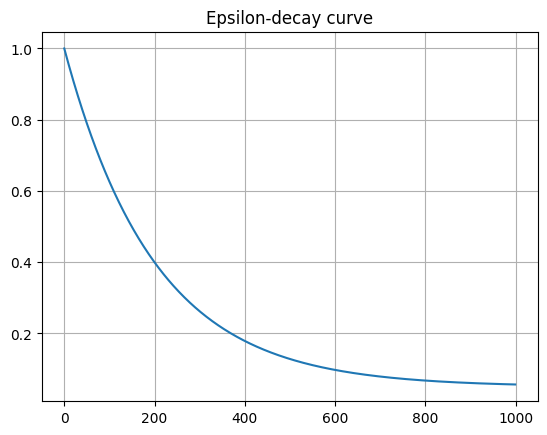

In [4]:
def epsilon_decay(t,eps_max=1,eps_min=0.05,eps_decay=200):
    return eps_min+(eps_max-eps_min)*np.exp(-1*t/eps_decay)

ts = np.arange(1000)

epsilon = []
for t in ts:
    eps = epsilon_decay(t)
    epsilon.append(eps)
plt.plot(epsilon)
plt.grid()
plt.title('Epsilon-decay curve')

### Replay Memory
Q 함수 학습의 Low-variance, High-bias 문제를 해결

$\theta \leftarrow \theta + \alpha (R + \gamma \underset{a}{max} Q_\hat{\theta}(s',a) - Q_\theta(s,a))\triangledown_\theta Q_\theta(s,a)$
- $\theta$ : 신경망 파라미터
- state ($s$), action ($a$), next_state ($s'$), reward ($R$)


In [5]:
class ReplayBuffer(object):
    def __init__(self,size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0
        
    def __len__(self):
        return len(self._storage)
    
    def add(self,obs_t,action,reward,obs_tp,done):
        data = (obs_t,action,reward,obs_tp,done)
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = int((self._next_idx + 1) % self._maxsize)
        
    def _encode_sample(self,idxes):
        obs_ts, actions, rewards, obs_tps, dones = [],[],[],[],[]
        for idx in idxes:
            obs_t, action, reward, obs_tp, done = self._storage[idx]
            obs_ts.append(obs_t)
            actions.append(action)
            rewards.append(reward)
            obs_tps.append(obs_tp)
            dones.append(done)
        return (
                np.array(obs_ts),
                np.array(actions),
                np.array(rewards),
                np.array(obs_tps),
                np.array(dones)
            )
    def sample(self,batch_size):
        idxes = np.random.choice(range(self.__len__()),batch_size)
        return self._encode_sample(idxes)

In [6]:
env._max_episode_steps=2000

gamma=0.99
epsilon_start = 1.0
epsilon_finish = 0.1
epsilon_sig=1000

state = env.reset()
state = state[0]
num_state = state.shape
num_action = env.action_space.n
learning_rate = 1e-04
max_episode = 10000
num_random_init = 100
batch_size=32
model_update_period=10

train_agent = DQN_SimpleAgent(state.shape,env.action_space.n,epsilon_start)
optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate)

target_agent = DQN_SimpleAgent(state.shape,env.action_space.n,epsilon_start)
target_agent.load_state_dict(train_agent.state_dict())

replay_buffer = ReplayBuffer(5000)
criterion = nn.MSELoss()

# Random init buffer를 채워줌
state = env.reset()
state = state[0]
for _ in range(num_random_init):
    action = env.action_space.sample()
    next_state,reward,done,_,info = env.step(action)
    replay_buffer.add(state,action,reward,next_state,done)
    if done:
        state = env.reset()
        state = state[0]
    state = next_state

### TD Loss
**Input**
- batch_sample : 리플레이로부터 받은 샘플(S,A,R,S',done)
- train_agent : 훈련에이전트
- target_agent : 타겟에이전트
- gamma - 할인율
  
**Output**

$Loss = \sum (R + \gamma \underset{a}{max} Q_\hat{\theta}(s',a) - Q_\theta(s,a))^2$

In [7]:
def TD_loss(batch_sample,train_agent,target_agent,env,gamma=gamma):

    states,actions,rewards,next_states,dones = batch_sample

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.ByteTensor(dones)
    not_dones = 1-dones
    
    train_Q = train_agent(states)
    target_Q = target_agent(next_states)
    train_Q = train_Q[range(len(actions)), actions]
    
    TD_target = rewards+not_dones*gamma*torch.max(target_Q,dim=-1).values
    loss = torch.mean((TD_target.detach()-train_Q)**2)
    return loss

### Training

400번째 에피소드 결과
Epsilon: 0.17856851907478205
최근 100 에피소드 보상평균 = 1095.72
최근 100 에피소드 TD오차 = 0.4289232551274427


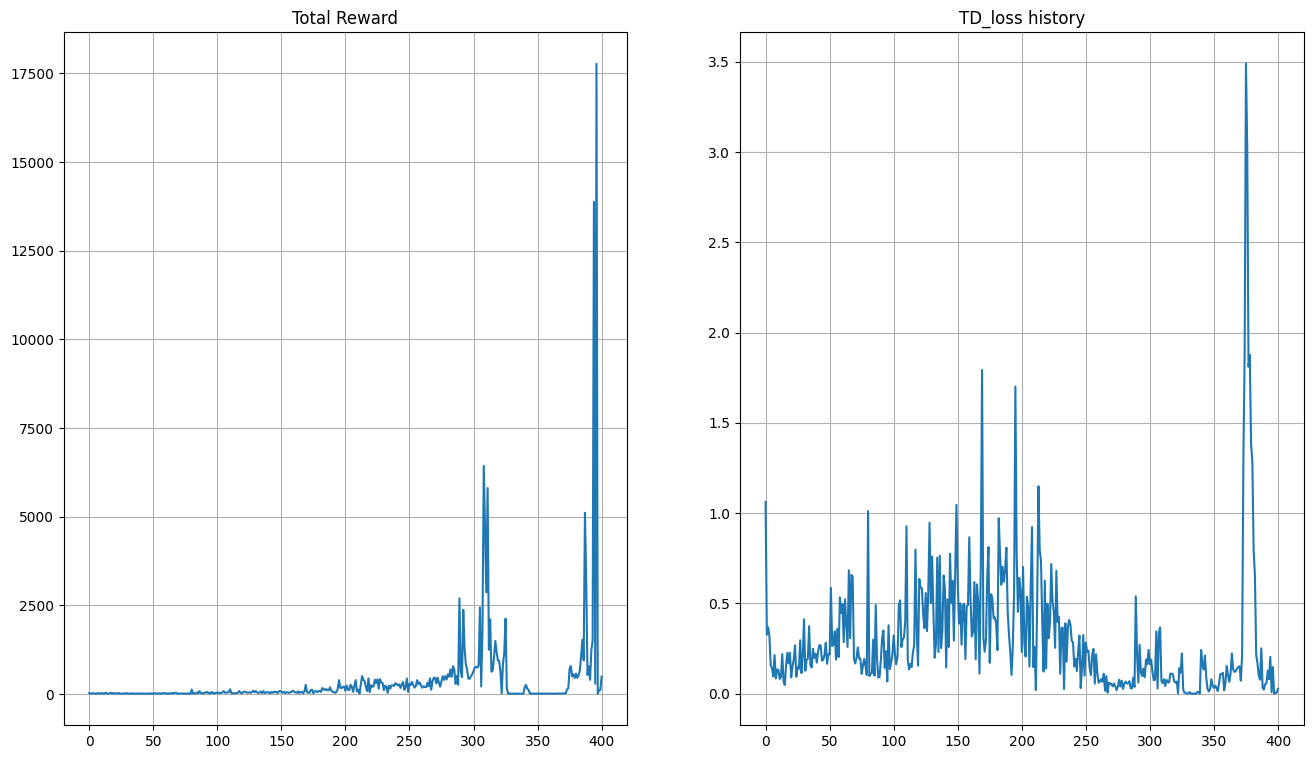

충분한 보상: 1521.0
학습종료


In [8]:
reward_record, TDloss_record = [], []
cnt = 0

for ep in range(max_episode):
    done = False
    state = env.reset()
    state = state[0]
    
    total_reward = 0
    mean_episode_TD = 0
    while True:
        torch_state = torch.FloatTensor(state)
        qvalues = train_agent(torch.unsqueeze(torch_state,0))
        action = train_agent.get_actions(qvalues)

        next_state,reward,done,_,_ = env.step(action[0])
        replay_buffer.add(state,action[0],reward,next_state,done)

        batch_sample = replay_buffer.sample(batch_size)
        loss = TD_loss(batch_sample,train_agent,target_agent,env,gamma=gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_episode_TD += loss.item()
        total_reward += reward
        
        if cnt % model_update_period == 0:
            target_agent.load_state_dict(train_agent.state_dict())
            
        if done:
            mean_episode_TD /= cnt    
            TDloss_record.append(mean_episode_TD)
            reward_record.append(total_reward)
            break
        
        # 업데이트
        state = next_state
        #train_agent.epsilon = epsilon_decay(ep,sig=epsilon_sig,low_bound=epsilon_finish)
        train_agent.epsilon = epsilon_decay(ep,eps_max=1,eps_min=0.05,eps_decay=200)
        cnt += 1

    if ep % 100 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'Epsilon: {train_agent.epsilon}')
        print(f'최근 100 에피소드 보상평균 = {np.mean(reward_record[-50:])}')
        print(f'최근 100 에피소드 TD오차 = {np.mean(TDloss_record[-50:])}')
        
        plt.figure(figsize=[16, 9])
        
        plt.subplot(1,2,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        # plt.plot(moving_average(reward_record))
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.title("TD_loss history")
        plt.plot(TDloss_record)
        # plt.plot(moving_average(TDloss_record))
        plt.grid()
        
        plt.show()
    
    if np.mean(reward_record[-50:]) >= 1500:
        print(f"충분한 보상: {np.mean(reward_record[-50:])}")
        print(f"학습종료")
        break